# Import Library

Pada tahap ini, semua library yang diperlukan diimpor agar fungsi dan alat bantu dari library tersebut dapat langsung digunakan dalam proses pengolahan data atau analisis selanjutnya. Dengan mengimpor semua library yang dibutuhkan di awal, kita memastikan bahwa semua fitur penting sudah siap dan tersedia, sehingga memudahkan serta mempercepat jalannya program tanpa harus mengimpor library secara terpisah di tengah-tengah proses.

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from itertools import product
import warnings
warnings.filterwarnings('ignore')

C:\Users\ljhab\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

Tahap pertama adalah memuat dataset suhu permukaan bulanan. Dataset ini berisi nilai suhu rata-rata bulanan dalam derajat Celsius, yang akan digunakan untuk analisis dan pemodelan time series.

Tujuan dari tahap ini adalah memastikan bahwa struktur dan isi data sudah sesuai sebelum masuk ke tahap praproses lebih lanjut.

**Hasil Utama**:
- Terdapat 198900 total baris data
- 6 total kolom data:
| Column                        | Non-Null Count   | Dtype   |
| ----------------------------- | ---------------- | ------- |
| Entity                        | 198,900 non-null | object  |
| Code                          | 198,900 non-null | object  |
| year                          | 198,900 non-null | int64   |
| Day                           | 198,900 non-null | object  |
| Average surface temperature   | 198,900 non-null | float64 |
| Average surface temperature.1 | 198,900 non-null | float64 |

In [2]:
# Load data CSV
df = pd.read_csv("average-monthly-surface-temperature.csv")

# Tampilkan 5 baris pertama
df.head()

,Entity,Code,year,Day,Average surface temperature,Average surface temperature.1
0,Afghanistan,AFG,1940,1940-01-15,-2.032494,11.327695
1,Afghanistan,AFG,1940,1940-02-15,-0.733503,11.327695
2,Afghanistan,AFG,1940,1940-03-15,1.999134,11.327695
3,Afghanistan,AFG,1940,1940-04-15,10.199754,11.327695
4,Afghanistan,AFG,1940,1940-05-15,17.942135,11.327695


In [3]:
# Info struktur dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Entity                         198900 non-null  object 
 1   Code                           198900 non-null  object 
 2   year                           198900 non-null  int64  
 3   Day                            198900 non-null  object 
 4   Average surface temperature    198900 non-null  float64
 5   Average surface temperature.1  198900 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.1+ MB


# Data Understanding I

Tahap ini bertujuan untuk memahami kondisi awal dataset sebelum dilakukan preprocessing. Beberapa pemeriksaan dasar dilakukan untuk mengidentifikasi kualitas data, potensi masalah, serta karakteristik utama data suhu permukaan, diantaranya:
- Pemeriksaan Missing Values dan Duplikasi: Untuk memastikan tidak ada data hilang atau duplikat setelah filtering data untuk Indonesia.
- Statistik Deskriptif: Mengamati karakteristik distribusi suhu setelah difilter berdasarkan negara.
- Cakupan Waktu Data: Memeriksa cakupan rentang tahun data yang tersedia
- Pemeriksaan Entitas/Negara: Mengetahui jumlah dan jenis entitas yang terdapat dalam dataset.
- Deteksi Outlier: Menggunakan metode IQR (Interquartile Range) untuk mengetahui apakah ada nilai ekstrem yang tidak wajar.

**Temuan Utama**:
- Tidak terdapat data **null** maupun data **duplikat**.
- 
| Statistik | Avg Temp (.0) | Avg Temp (.1)  |
|-----------|---------------|----------------|
| Mean      | 18.07 °C      | 18.07 °C       |
| Std Dev   | 10.25 °C      | 8.71 °C        |
| Min       | -36.24 °C     | -21.53 °C      |
| Max       | 39.89 °C      | 29.79 °C       |
- Periode data mencakup tahun **1940 hingga 2024**.
- Terdapat **195 entitas unik** dalam data (`Entity`), mencakup negara-negara dan wilayah global.
- Total baris unik yang mengandung outlier: 4381

## Cek null data

In [4]:
df.isnull().sum()

Entity                           0
Code                             0
year                             0
Day                              0
Average surface temperature      0
Average surface temperature.1    0
dtype: int64

## Cek Duplicate Data

In [5]:
df.duplicated().sum()

0

## Statistik deskriptif

In [6]:
df[['Average surface temperature', 'Average surface temperature.1']].describe()

,Average surface temperature,Average surface temperature.1
count,198900.000000,198900.000000
mean,18.072073,18.072073
std,10.246142,8.710114
min,-36.240032,-21.529121
25%,12.304079,10.569263
50%,22.055794,21.856285
75%,25.317015,25.142885
max,39.889374,29.794220


## Cek Rentang waktu

In [7]:
df['year'].max(), df['year'].min()

(2024, 1940)

## Cek Entitas Unik

In [8]:
df['Entity'].nunique()

195

In [9]:
df['Entity'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Falkland Islands', 'Faroe Islands',
       'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 

## Cek Outlier

In [10]:
cols = ['Average surface temperature', 'Average surface temperature.1']
all_outlier_indices = set()

for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    all_outlier_indices.update(outliers.index)

    print(f"\nKolom: {col}")
    print(f"Jumlah outlier: {len(outliers)}")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

print(f"\nTotal baris unik yang mengandung outlier: {len(all_outlier_indices)}")


Kolom: Average surface temperature
Jumlah outlier: 4226
Lower Bound: -7.22, Upper Bound: 44.84

Kolom: Average surface temperature.1
Jumlah outlier: 1020
Lower Bound: -11.29, Upper Bound: 47.00

Total baris unik yang mengandung outlier: 4381


# Data Preprocessing

Tahap ini dilakukan untuk menyiapkan data agar siap digunakan dalam proses modeling. Fokus utama adalah memfilter data yang relevan, memastikan format waktu benar, serta memastikan kelengkapan data waktu secara konsisten.

- Filtering Indonesia Surface Temperature Only: penyaringan data untuk hanya menyertakan observasi yang berasal dari **Indonesia**. Hal ini dilakukan agar analisis berfokus pada wilayah yang relevan secara geografis dengan tujuan studi perubahan iklim di Indonesia.
- Penyesuaian Tipe Data: Mengubah kolom Day menjadi format datetime agar dapat dimanfaatkan untuk manipulasi waktu dan pengelompokan data bulanan
- Pengecekan tidak ada bulan yang terlewat dalam data: Membuat kolom baru untuk representasi bulan dalam format period (YYYY-MM), yang berguna untuk analisis musiman serta melakukan pengecekan apakah terdapat bulan yang hilang dalam rentang waktu data (1940-01 sampai 2024-12), untuk memastikan data deret waktu lengkap dan tidak ada missing period.

**Temuan Utama:**
- Data berhasil difilter untuk Indonesia dengan total baris 1020.
- Tipe data tanggal sudah disesuaikan dengan benar
- Tidak ditemukan bulan yang hilang dalam rentang waktu analisis, sehingga data bulanan sudah lengkap dan siap untuk modeling time series.

## Filtering Indonesia Surface Temperature Only

In [11]:
data = df[df['Entity'] == 'Indonesia'].reset_index(drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Entity                         1020 non-null   object 
 1   Code                           1020 non-null   object 
 2   year                           1020 non-null   int64  
 3   Day                            1020 non-null   object 
 4   Average surface temperature    1020 non-null   float64
 5   Average surface temperature.1  1020 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 47.9+ KB


## Penyesuaian Tipe Data

In [12]:
data['Day'] = pd.to_datetime(data['Day'])

## Pengecekan tidak ada bulan yang terlewat dalam data

In [13]:
data['Day'].min(), data['Day'].max()

(Timestamp('1940-01-15 00:00:00'), Timestamp('2024-12-15 00:00:00'))

In [14]:
data['month'] = data['Day'].dt.to_period('M')  # format: YYYY-MM
bulan_ada = data['month'].unique()
bulan_ada = sorted(bulan_ada)

semua_bulan = pd.period_range(start='1940-01', end='2024-12', freq='M')

# Cek bulan yang hilang
bulan_hilang = set(semua_bulan) - set(bulan_ada)
print("Bulan yang hilang:", sorted(bulan_hilang))

Bulan yang hilang: []


## Data Understanding II

Tahap ini bertujuan untuk memahami kondisi dataset setelah dilakukan preprocessing. Beberapa pemeriksaan dasar dilakukan untuk mengidentifikasi kualitas data, potensi masalah, serta karakteristik utama data suhu permukaan, diantaranya:

- Pemeriksaan Missing Values dan Duplikasi: Untuk memastikan tidak ada data hilang atau duplikat setelah filtering data untuk Indonesia.
- Statistik Deskriptif: Mengamati karakteristik distribusi suhu setelah difilter berdasarkan negara.
- Eksplorasi Nilai Unik: Untuk memahami variasi data pada setiap kolom dan mendeteksi kemungkinan data redundan.
- Deteksi Outlier: Menggunakan metode IQR (Interquartile Range) untuk mengetahui apakah ada nilai ekstrem yang tidak wajar.

**Temuan Utama**:
- Tidak terdapat data **null** maupun data **duplikat**.
- 
| Statistik | Average surface temperature | Average surface temperature.1 |
| --------- | --------------------------- | ----------------------------- |
| Mean      | 24.61 °C                    | 24.61 °C                      |
| Std Dev   | 0.64 °C                     | 0.58 °C                       |
| Min       | 23.14 °C                    | 23.64 °C                      |
| Max       | 26.48 °C                    | 26.01 °C                      |

- Data sudah sesuai hanya berisikan Indonesia
- Total baris tidak mengandung outlier.


## Cek Null Data

In [15]:
data.isnull().sum()

Entity                           0
Code                             0
year                             0
Day                              0
Average surface temperature      0
Average surface temperature.1    0
month                            0
dtype: int64

## Cek Duplikat data

In [16]:
data.duplicated().sum()

0

## Statistik Deskriptif

In [17]:
data[['Average surface temperature', 'Average surface temperature.1']].describe()

,Average surface temperature,Average surface temperature.1
count,1020.000000,1020.000000
mean,24.607071,24.607071
std,0.635861,0.575478
min,23.137548,23.644049
25%,24.112764,24.157072
50%,24.560066,24.535385
75%,25.069886,25.052223
max,26.479654,26.005700


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Entity                         1020 non-null   object        
 1   Code                           1020 non-null   object        
 2   year                           1020 non-null   int64         
 3   Day                            1020 non-null   datetime64[ns]
 4   Average surface temperature    1020 non-null   float64       
 5   Average surface temperature.1  1020 non-null   float64       
 6   month                          1020 non-null   period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(2), period[M](1)
memory usage: 55.9+ KB


## Cek unique value

In [19]:
for col in data.columns:
    unique_values = data[col].unique()
    print(f"Kolom '{col}' memiliki {len(unique_values)} nilai unik:")
    print(unique_values)
    print('-' * 30)

Kolom 'Entity' memiliki 1 nilai unik:
['Indonesia']
------------------------------
Kolom 'Code' memiliki 1 nilai unik:
['IDN']
------------------------------
Kolom 'year' memiliki 85 nilai unik:
[1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953
 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967
 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981
 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024]
------------------------------
Kolom 'Day' memiliki 1020 nilai unik:
<DatetimeArray>
['1940-01-15 00:00:00', '1940-02-15 00:00:00', '1940-03-15 00:00:00',
 '1940-04-15 00:00:00', '1940-05-15 00:00:00', '1940-06-15 00:00:00',
 '1940-07-15 00:00:00', '1940-08-15 00:00:00', '1940-09-15 00:00:00',
 '1940-10-15 00:00:00',
 ...
 '2024-03-15 00:00:00', '2024-04-15 00:00:00', '

## Cek Outlier

In [20]:
cols = ['Average surface temperature', 'Average surface temperature.1']
all_outlier_indices = set()

for col in cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    all_outlier_indices.update(outliers.index)

    print(f"\nKolom: {col}")
    print(f"Jumlah outlier: {len(outliers)}")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

print(f"\nTotal baris unik yang mengandung outlier: {len(all_outlier_indices)}")


Kolom: Average surface temperature
Jumlah outlier: 0
Lower Bound: 22.68, Upper Bound: 26.51

Kolom: Average surface temperature.1
Jumlah outlier: 0
Lower Bound: 22.81, Upper Bound: 26.39

Total baris unik yang mengandung outlier: 0


# EDA

Tahap ini bertujuan untuk menggali lebih dalam karakteristik data suhu permukaan di Indonesia, baik dari sisi distribusi statistik, pola historis jangka panjang, maupun variasi musiman. Analisis dilakukan melalui visualisasi dan perhitungan statistik dasar.

- Distribusi Data Suhu Permukaan: Untuk memahami bentuk distribusi dari data suhu, mengevaluasi normalitas, serta mengidentifikasi potensi skewness dan kurtosis yang bisa mempengaruhi model statistik atau machine learning.
- Tren Historis Suhu Permukaan: Untuk melihat dinamika perubahan suhu dari waktu ke waktu dan mendeteksi adanya tren jangka panjang.
- Tren Musiman Suhu Permukaan: Untuk mengevaluasi variasi suhu berdasarkan bulan guna mendeteksi pola musiman yang mungkin relevan secara klimatologis.

**Temuan Utama:**
- Distribusi yang cukup simetris
| Kolom                         | Skewness | Kurtosis | Std Dev |
| ----------------------------- | -------- | -------- | ------- |
| Average surface temperature   | 0.30     | -0.52    | 0.64    |
| Average surface temperature.1 | 0.36     | -0.83    | 0.58    |
- Terlihat tren kenaikan suhu yang cukup signifikan, terutama sejak awal 1980-an. Suhu yang awalnya berkisar di 24°C kini sering melewati 25.5°C dan bahkan mendekati 26.5°C.
- Suhu rata-rata bulanan berada dalam rentang sempit (~0.6°C), khas iklim tropis. Bulan dengan suhu tertinggi: Mei dan Oktober. Bulan dengan suhu terendah: Juli.

## Visualisasi dan Cek Distribusi data

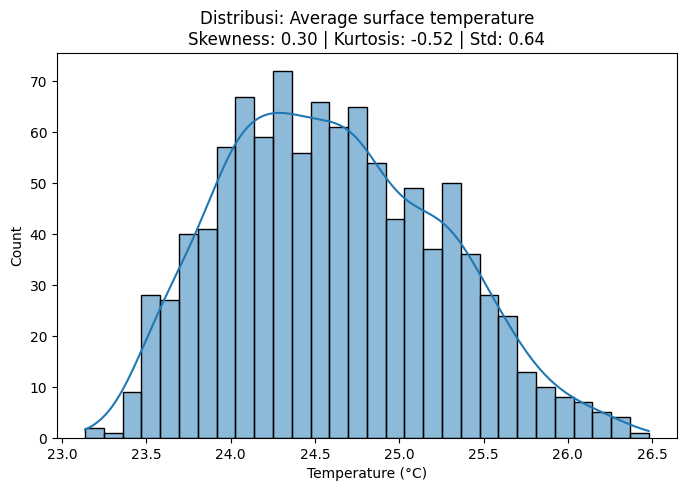

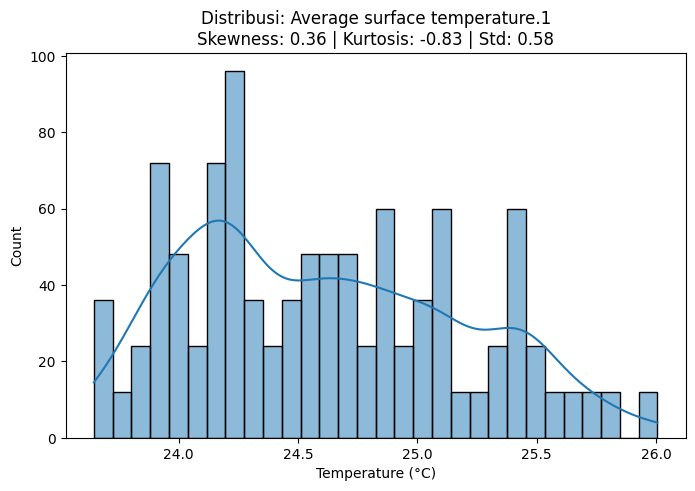

In [21]:
distribution = data[['Average surface temperature', 'Average surface temperature.1']]

for col in distribution:
    plt.figure(figsize=(8,5))
    sns.histplot(data[col], bins=30, kde=True)

    mean = data[col].mean()
    median = data[col].median()
    std = data[col].std()
    skewness = skew(data[col].dropna())
    kurt = kurtosis(data[col].dropna())

    
    plt.title(f'Distribusi: {col}\nSkewness: {skewness:.2f} | Kurtosis: {kurt:.2f} | Std: {std:.2f}')
    plt.xlabel('Temperature (°C)')

## Visualisasi Tren Historis Data Surface Temperature

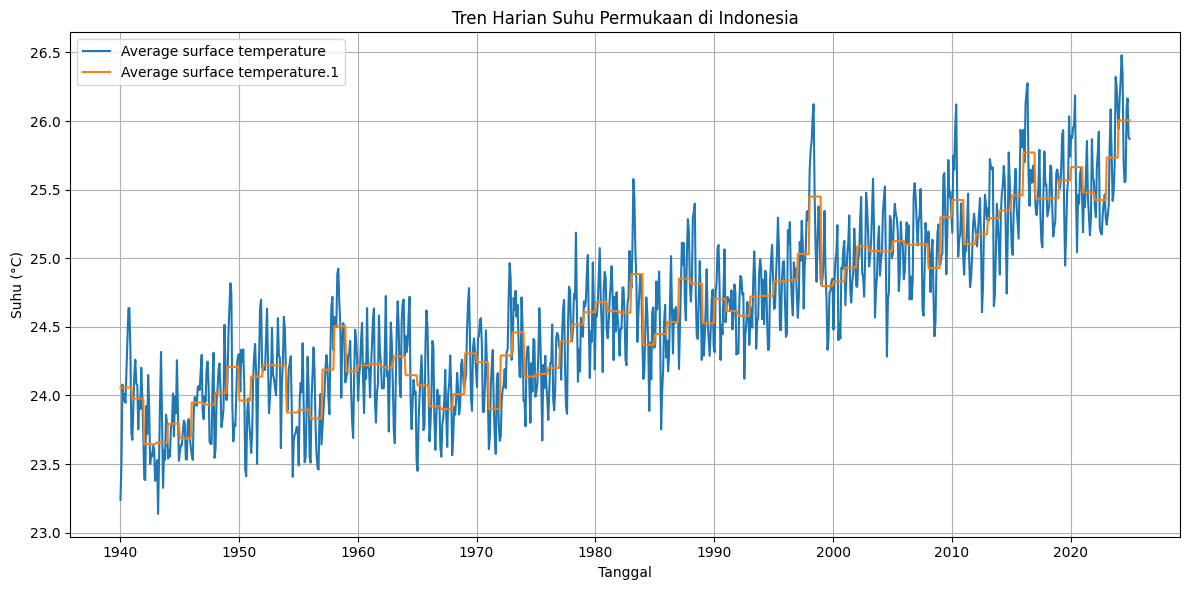

In [22]:
plt.figure(figsize=(12,6))

sns.lineplot(data=data, x='Day', y='Average surface temperature', label='Average surface temperature')
sns.lineplot(data=data, x='Day', y='Average surface temperature.1', label='Average surface temperature.1')

plt.title('Tren Harian Suhu Permukaan di Indonesia')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Terlihat tren kenaikan suhu yang signifikan dari waktu ke waktu, khususnya mulai tahun 1980-an ke atas. Suhu yang awalnya berkisar di sekitar 24°C kini sering melewati 25.5°C bahkan mendekati 26.5°C.

Indonesia mengalami pemanasan jangka panjang, yang bisa berdampak pada iklim, pertanian, kesehatan, dan keanekaragaman hayati.

## Visualisasi Tren Historis Surface Temperature berdasarkan bulan

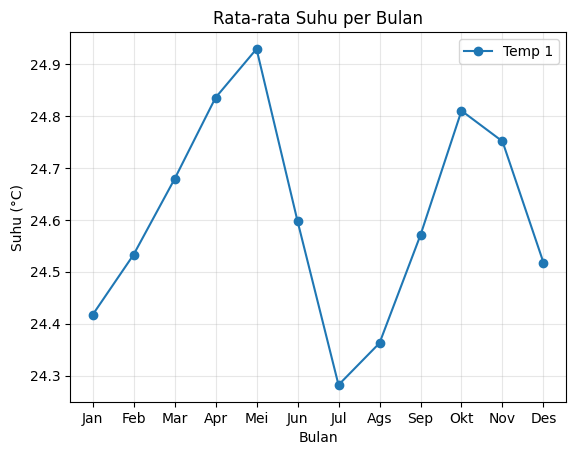

In [23]:
data['month_num'] = data['month'].dt.month

# Rata-rata suhu per bulan
monthly_avg = data.groupby('month_num')[['Average surface temperature']].mean()
monthly_avg.plot(kind='line', marker='o')
plt.title('Rata-rata Suhu per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Suhu (°C)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 
                          'Jul', 'Ags', 'Sep', 'Okt', 'Nov', 'Des'])
plt.legend(['Temp 1', 'Temp 2'])
plt.grid(True, alpha=0.3)

Indonesia memiliki variasi musiman suhu yang tidak ekstrem, karena merupakan negara tropis.

Suhu di Indonesia berfluktuasi secara musiman, tetapi tetap dalam rentang sempit (~0.6°C per tahun), khas iklim tropis.

Rata-rata suhu permukaan tertinggi berada pada bulan Mei dan Oktober, sedangkan rata-rata suhu permukaan terendah berada pada bulan Juli.

# Modelling (ARIMA, AUTOARIMA, dan Prophet)

Tahap ini bertujuan untuk melakukan peramalan suhu permukaan bulanan di Indonesia menggunakan tiga pendekatan model time series: ARIMA, AutoARIMA, dan Prophet. Setiap model dievaluasi berdasarkan kinerja prediksinya terhadap data uji (test set), menggunakan beberapa metrik evaluasi umum seperti RMSE, MAE, MAPE, dan SMAPE.

1. Data Preparation
Tahap ini bertujuan untuk mempersiapkan data suhu permukaan dalam format yang sesuai untuk pemodelan time series. Data yang telah dibersihkan dan dianalisis sebelumnya perlu ditransformasi agar dapat digunakan oleh algoritma forecasting, diantaranya:
- Konversi Format Waktu: Mengubah kolom 'month' dari format period menjadi timestamp untuk kompatibilitas dengan library forecasting.
- Standardisasi Kolom: Menyesuaikan nama kolom menjadi format standar ('ds' untuk datetime, 'y' untuk target variable) yang umum digunakan dalam time series modeling.
- Pemisahan Data: Melakukan split data dengan rasio 80:20 untuk training dan testing untuk evaluasi model yang objektif.
  
2. Data Modelling
- Model ARIMA dibangun secara manual dengan parameter (1,1,1).
- AutoARIMA secara otomatis memilih parameter terbaik berdasarkan evaluasi iteratif dengan pendekatan stepwise.
- Prophet menggunakan pendekatan aditif untuk memodelkan tren dan pola musiman, serta dirancang agar robust terhadap missing values dan perubahan musiman yang tidak teratur.

**Hasil:**
-
| Model         | RMSE  | MAE   | MAPE  | SMAPE |
| ------------- | ----- | ----- | ----- | ----- |
| **ARIMA**     | 0.423 | 0.361 | 1.41% | 1.42% |
| **AutoARIMA** | 0.423 | 0.361 | 1.41% | 1.42% |
| **Prophet**   | 0.195 | 0.148 | 0.58% | 0.58% |

## Data preparation

In [24]:
# Konversi Format Waktu
data['month'] = data['month'].dt.to_timestamp()

# Standardisasi Kolom
monthly_ts = data[['month', 'Average surface temperature.1']].copy()
monthly_ts.columns = ['ds', 'y']

monthly_ts_arima = monthly_ts.set_index('ds')

## Data modelling

In [25]:
# Fungsi MAPE dan SMAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Split data 80:20
train_size = int(len(monthly_ts) * 0.8)
train = monthly_ts.iloc[:train_size]
test = monthly_ts.iloc[train_size:]

# ARIMA MODEL
train_arima = train.set_index('ds')
model_arima = ARIMA(train_arima, order=(1,1,1))
model_fit = model_arima.fit()
forecast_arima = model_fit.forecast(steps=len(test))

y_true = test['y'].values
y_pred_arima = forecast_arima.values

rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mae_arima = mean_absolute_error(y_true, y_pred_arima)
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)
smape_arima = symmetric_mean_absolute_percentage_error(y_true, y_pred_arima)

print("ARIMA Performance:")
print(f"  RMSE : {rmse_arima:.3f}")
print(f"  MAE  : {mae_arima:.3f}")
print(f"  MAPE : {mape_arima:.2f}%")
print(f"  SMAPE: {smape_arima:.2f}%\n")

# AUTO ARIMA MODEL
train_autoarima = train.set_index('ds')
model_autoarima = auto_arima(train_autoarima, seasonal=True, stepwise=True, suppress_warnings=True)
forecast_autoarima = model_autoarima.predict(n_periods=len(test))

y_pred_autoarima = forecast_autoarima

rmse_autoarima = np.sqrt(mean_squared_error(y_true, y_pred_autoarima))
mae_autoarima = mean_absolute_error(y_true, y_pred_autoarima)
mape_autoarima = mean_absolute_percentage_error(y_true, y_pred_autoarima)
smape_autoarima = symmetric_mean_absolute_percentage_error(y_true, y_pred_autoarima)

print("AutoARIMA Performance:")
print(f"  RMSE : {rmse_autoarima:.3f}")
print(f"  MAE  : {mae_autoarima:.3f}")
print(f"  MAPE : {mape_autoarima:.2f}%")
print(f"  SMAPE: {smape_autoarima:.2f}%\n")

# PROPHET MODEL
prophet_train = train.copy()
prophet_model = Prophet()
prophet_model.fit(prophet_train)

future_test = prophet_model.make_future_dataframe(periods=len(test), freq='M')
forecast_prophet = prophet_model.predict(future_test)

y_pred_prophet = forecast_prophet.iloc[-len(test):]['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
mape_prophet = mean_absolute_percentage_error(y_true, y_pred_prophet)
smape_prophet = symmetric_mean_absolute_percentage_error(y_true, y_pred_prophet)

print("Prophet Performance:")
print(f"  RMSE : {rmse_prophet:.3f}")
print(f"  MAE  : {mae_prophet:.3f}")
print(f"  MAPE : {mape_prophet:.2f}%")
print(f"  SMAPE: {smape_prophet:.2f}%")

ARIMA Performance:
  RMSE : 0.423
  MAE  : 0.361
  MAPE : 1.41%
  SMAPE: 1.42%

AutoARIMA Performance:
  RMSE : 0.423
  MAE  : 0.361
  MAPE : 1.41%
  SMAPE: 1.42%



17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet Performance:
  RMSE : 0.195
  MAE  : 0.148
  MAPE : 0.58%
  SMAPE: 0.58%


In [26]:
print(f"AutoARIMA selected parameters: {model_autoarima.order}")
print(f"Seasonal parameters: {model_autoarima.seasonal_order}")

AutoARIMA selected parameters: (0, 1, 0)
Seasonal parameters: (0, 0, 0, 0)


# Evaluasi Model

Tahap ini bertujuan untuk melakukan evaluasi komprehensif terhadap ketiga model forecasting yang telah diimplementasikan. Evaluasi dilakukan menggunakan multiple metrics untuk mendapatkan gambaran yang menyeluruh tentang performa masing-masing model, diantaranya:

- Quantitative Assessment: Menggunakan empat metrics utama (RMSE, MAE, MAPE, SMAPE) untuk mengukur akurasi prediksi
- Visual Comparison: Membandingkan prediksi model dengan data aktual melalui time series plot
- Residual Analysis: Menganalisis pola error untuk mengevaluasi kualitas fitting model

**Hasil:**
- Prophet mengungguli ARIMA dan AutoARIMA secara signifikan di semua metrik evaluasi
| Model         | RMSE  | MAE   | MAPE  | SMAPE |
| ------------- | ----- | ----- | ----- | ----- |
| **ARIMA**     | 0.423 | 0.361 | 1.41% | 1.42% |
| **AutoARIMA** | 0.423 | 0.361 | 1.41% | 1.42% |
| **Prophet**   | 0.195 | 0.148 | 0.58% | 0.58% |
- Plot perbandingan prediksi memperlihatkan Prophet mengikuti pola data asli lebih baik.
- Residual Prophet berdistribusi simetris dan acak tanpa pola sistematis → menandakan model sudah fit dengan baik dan tidak bias.

Model Comparison:
           Model   RMSE    MAE   MAPE  SMAPE
0  ARIMA (1,1,1)  0.423  0.361  1.409  1.423
1      AutoARIMA  0.423  0.361  1.409  1.423
2        Prophet  0.195  0.148  0.580  0.582


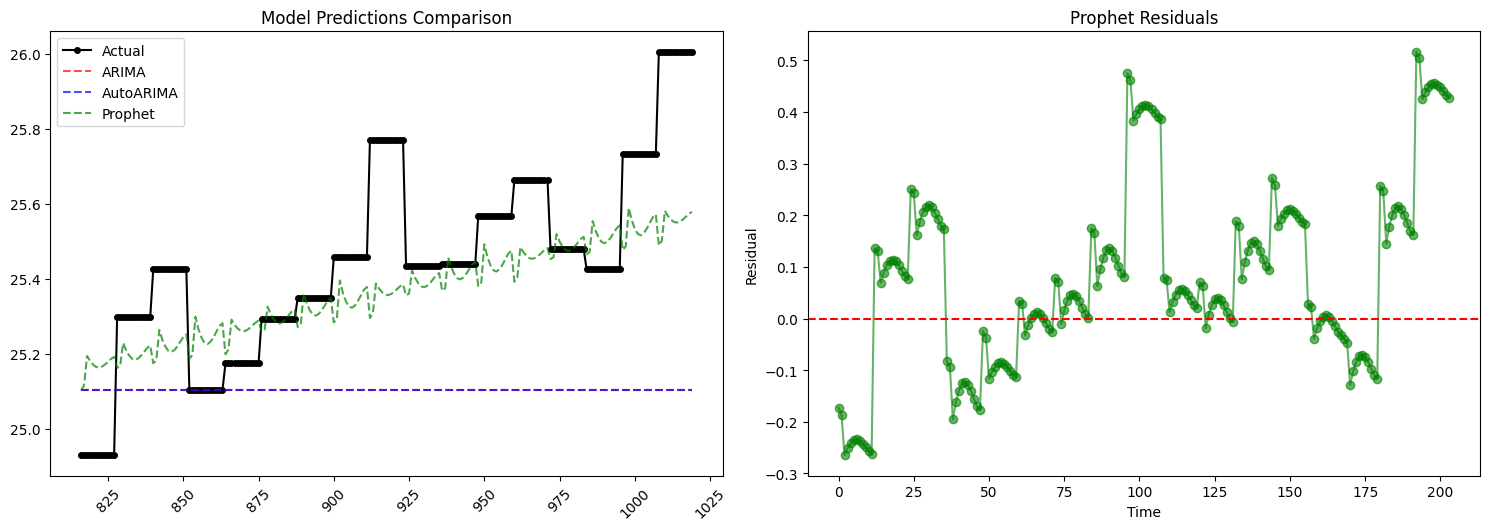

In [27]:
results_df = pd.DataFrame({
    'Model': ['ARIMA (1,1,1)', 'AutoARIMA', 'Prophet'],
    'RMSE': [rmse_arima, rmse_autoarima, rmse_prophet],
    'MAE': [mae_arima, mae_autoarima, mae_prophet], 
    'MAPE': [mape_arima, mape_autoarima, mape_prophet],
    'SMAPE': [smape_arima, smape_autoarima, smape_prophet]
})
print("Model Comparison:")
print(results_df.round(3))

# Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

# Plot 1: Time series comparison
plt.subplot(2,2,1)
plt.plot(test.index, y_true, 'ko-', label='Actual', markersize=4)
plt.plot(test.index, y_pred_arima, 'r--', label='ARIMA', alpha=0.7)
plt.plot(test.index, y_pred_autoarima, 'b--', label='AutoARIMA', alpha=0.7)
plt.plot(test.index, y_pred_prophet, 'g--', label='Prophet', alpha=0.7)
plt.title('Model Predictions Comparison')
plt.legend()
plt.xticks(rotation=45)

# Plot 2: Residuals
plt.subplot(2,2,2)
residuals_prophet = y_true - y_pred_prophet
plt.plot(residuals_prophet, 'go-', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Prophet Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

Prophet mengungguli ARIMA dan AutoARIMA secara signifikan di semua metrik.

**Model Comparison:**

Model Prophet paling mengikuti pola data aktual, terutama dalam menangkap tren dan perubahan.

ARIMA dan AutoARIMA menghasilkan prediksi yang hampir identik (seperti terlihat juga dari metrik performa), namun prediksi mereka terlalu datar dan kurang responsif terhadap fluktuasi data.

**Prophet Residuals:**

Sebagian besar residual berada dekat dengan garis nol → model Prophet memberikan prediksi yang akurat.

Tidak terlihat pola sistematis dalam residual → mengindikasikan bahwa Prophet sudah cukup baik menangkap pola dalam data.

Variasi residual cukup simetris dan tersebar acak → tidak ada indikasi bias serius.

# Forecasting model Prophet

Tahap ini bertujuan untuk menghasilkan prediksi nilai time series menggunakan model Prophet yang telah terlatih. Prediksi dilakukan untuk periode testing serta 6 bulan tambahan ke depan guna melihat proyeksi jangka pendek.

- Forecast Horizon: Prediksi dilakukan untuk seluruh periode test ditambah 6 bulan ke depan (future periods = 6 bulan)
- Confidence Intervals: Model menghasilkan interval kepercayaan (lower dan upper bound) untuk mengukur ketidakpastian prediksi

**Hasil:**
-
| Tanggal    | Prediksi (yhat) | Lower Bound | Upper Bound |
| ---------- | --------------- | ----------- | ----------- |
| 2024-12-31 | 25.55           | 22.71       | 28.44       |
| 2025-01-31 | 25.55           | 22.71       | 28.51       |
| 2025-02-28 | 25.62           | 22.67       | 28.58       |
| 2025-03-31 | 25.60           | 22.66       | 28.57       |
| 2025-04-30 | 25.58           | 22.61       | 28.59       |
| 2025-05-31 | 25.57           | 22.62       | 28.61       |
- Prediksi cenderung stabil dengan sedikit kenaikan, sesuai pola tren yang telah dipelajari dari data historis.

Future 6 Months Forecast:
             ds       yhat  yhat_lower  yhat_upper
1020 2024-12-31  25.549088   22.903538   28.782524
1021 2025-01-31  25.553679   22.811499   28.773983
1022 2025-02-28  25.615482   22.895495   28.915081
1023 2025-03-31  25.595935   22.873245   28.997140
1024 2025-04-30  25.582025   22.836848   28.925613
1025 2025-05-31  25.573116   22.816925   28.932938


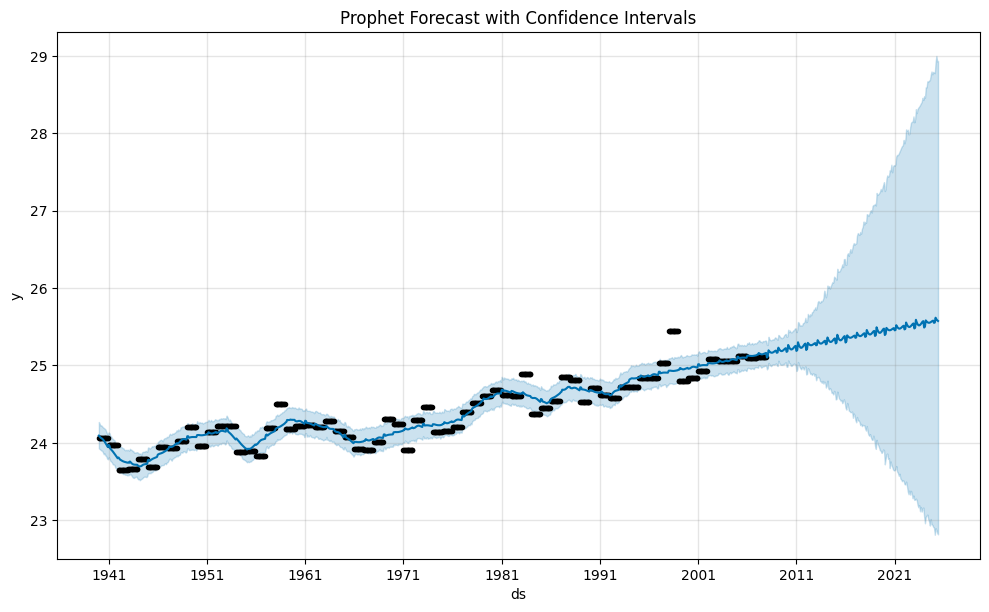

In [28]:
# Forecast 6 months
future_periods = 6
future_df = prophet_model.make_future_dataframe(periods=len(test) + future_periods, freq='M')
forecast_future = prophet_model.predict(future_df)

future_predictions = forecast_future.iloc[len(monthly_ts):][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("Future 6 Months Forecast:")
print(future_predictions)

# Plot confidence intervals
prophet_model.plot(forecast_future)
plt.title('Prophet Forecast with Confidence Intervals')
plt.show()

# Hyperparameter Tuning

Tujuan tahap ini adalah untuk mengoptimalkan performa model Prophet dengan mencari kombinasi hyperparameter terbaik menggunakan dua pendekatan:

1. Manual Grid Search: Mencoba berbagai kombinasi hyperparameter pada subset grid untuk menemukan konfigurasi dengan MAPE terendah.
- Hyperparameter yang diuji:

    changepoint_prior_scale: Mengatur fleksibilitas tren
    
    seasonality_prior_scale: Mengontrol kekuatan musiman
    
    holidays_prior_scale: Pengaruh hari libur
    
    seasonality_mode: Additive atau multiplicative
    
    changepoint_range: Rentang deteksi perubahan tren

- Proses:
Mencoba 20 kombinasi dari grid parameter yang telah ditentukan, mengukur performa dengan metrik RMSE, MAE, MAPE, dan SMAPE.


2. Cross-Validation: Melakukan evaluasi model secara lebih robust menggunakan time series cross-validation untuk memastikan generalisasi model.
3. Model final dilatih ulang menggunakan parameter terbaik hasil tuning.

**Hasil:**
- 
| Parameter                 | Nilai          |
| ------------------------- | -------------- |
| changepoint\_prior\_scale | 0.001          |
| seasonality\_prior\_scale | 0.01           |
| holidays\_prior\_scale    | 0.01           |
| seasonality\_mode         | multiplicative |
| changepoint\_range        | 0.9            |
- MAPE Terbaik: 0.6180%
- Hasil cross-validation menunjukkan MAPE rata-rata 0.5811%
- 
| Metrik | Nilai   |
| ------ | ------- |
| RMSE   | 0.2035  |
| MAE    | 0.1580  |
| MAPE   | 0.6180% |
| SMAPE  | 0.6205% |

**Kesimpulan:**
- Original MAPE: 0.58%
- Tuned MAPE: 0.6180%
- Model Prophet tanpa tuning sudah cukup optimal

In [29]:
def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape}

# 1. MANUAL TUNING

print("🔧 PROPHET HYPERPARAMETER TUNING")
print("="*50)

# Define hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   # Seasonality strength
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],      # Holiday effects
    'seasonality_mode': ['additive', 'multiplicative'],   # Seasonality type
    'changepoint_range': [0.8, 0.9, 0.95]                # Changepoint detection range
}

# Manual Grid Search
best_params = None
best_mape = float('inf')
results = []

print("🔍 Grid Search Progress:")
total_combinations = np.prod([len(v) for v in param_grid.values()])
current_combo = 0

# Sample a subset for faster execution (or run full grid if you have time)
sample_combinations = 20  # Reduce from full grid for demo

for i, (cp_scale, seas_scale, hol_scale, seas_mode, cp_range) in enumerate(
    list(product(*param_grid.values()))[:sample_combinations]
):
    current_combo += 1
    
    try:
        # Create model with current parameters
        model = Prophet(
            changepoint_prior_scale=cp_scale,
            seasonality_prior_scale=seas_scale,
            holidays_prior_scale=hol_scale,
            seasonality_mode=seas_mode,
            changepoint_range=cp_range,
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            interval_width=0.95
        )
        
        # Fit and predict
        model.fit(train)
        future = model.make_future_dataframe(periods=len(test), freq='M')
        forecast = model.predict(future)
        
        # Get predictions for test period
        y_pred = forecast.iloc[len(train):]['yhat'].values
        
        # Calculate metrics
        metrics = calculate_metrics(y_true, y_pred)
        
        # Store results
        result = {
            'changepoint_prior_scale': cp_scale,
            'seasonality_prior_scale': seas_scale,
            'holidays_prior_scale': hol_scale,
            'seasonality_mode': seas_mode,
            'changepoint_range': cp_range,
            **metrics
        }
        results.append(result)
        
        # Update best parameters
        if metrics['MAPE'] < best_mape:
            best_mape = metrics['MAPE']
            best_params = result.copy()
            
        # Progress update
        if current_combo % 5 == 0:
            print(f"   Completed {current_combo}/{sample_combinations} combinations... Best MAPE so far: {best_mape:.3f}%")
            
    except Exception as e:
        print(f"   Error with combination {current_combo}: {str(e)}")
        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 TUNING RESULTS:")
print("="*30)
print(f"Best MAPE achieved: {best_mape:.4f}%")
print("\nBest Parameters:")
for key, value in best_params.items():
    if key not in ['RMSE', 'MAE', 'MAPE', 'SMAPE']:
        print(f"  {key}: {value}")


# 2. ADVANCED TUNING WITH CROSS-VALIDATION

print("\n🎯 CROSS-VALIDATION TUNING")
print("="*35)

def cross_val_prophet(train_data, params, cv_folds=3):
    """Perform time series cross-validation for Prophet"""
    # Time series split
    n = len(train_data)
    fold_size = n // cv_folds
    
    cv_scores = []
    
    for fold in range(cv_folds):
        # Split data
        train_end = fold_size * (fold + 2)  # Progressive training
        if train_end > n:
            train_end = n
            
        cv_train = train_data.iloc[:train_end-fold_size]
        cv_test = train_data.iloc[train_end-fold_size:train_end]
        
        if len(cv_test) == 0:
            continue
            
        try:
            # Fit model
            model = Prophet(**params)
            model.fit(cv_train)
            
            # Predict
            future = model.make_future_dataframe(periods=len(cv_test), freq='M')
            forecast = model.predict(future)
            y_pred = forecast.iloc[len(cv_train):]['yhat'].values
            y_true = cv_test['y'].values
            
            # Calculate MAPE
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            cv_scores.append(mape)
            
        except:
            continue
    
    return np.mean(cv_scores) if cv_scores else float('inf')

# Best parameters from grid search
best_config = {
    'changepoint_prior_scale': best_params['changepoint_prior_scale'],
    'seasonality_prior_scale': best_params['seasonality_prior_scale'],
    'holidays_prior_scale': best_params['holidays_prior_scale'],
    'seasonality_mode': best_params['seasonality_mode'],
    'changepoint_range': best_params['changepoint_range'],
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False
}

# Cross-validate best model
cv_score = cross_val_prophet(train, best_config)
print(f"Cross-validation MAPE: {cv_score:.4f}%")

# 3. FINAL MODEL TRAINING & EVALUATION

print("\n🏆 FINAL TUNED MODEL")
print("="*25)

# Train final model with best parameters
final_model = Prophet(**best_config)
final_model.fit(train)

# Make predictions
future_final = final_model.make_future_dataframe(periods=len(test), freq='M')
forecast_final = final_model.predict(future_final)
y_pred_final = forecast_final.iloc[len(train):]['yhat'].values

# Calculate final metrics
final_metrics = calculate_metrics(y_true, y_pred_final)

print("Final Tuned Model Performance:")
for metric, value in final_metrics.items():
    print(f"  {metric}: {value:.4f}")

🔧 PROPHET HYPERPARAMETER TUNING
🔍 Grid Search Progress:


17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing


   Completed 5/20 combinations... Best MAPE so far: 0.618%


17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing


   Completed 10/20 combinations... Best MAPE so far: 0.618%


17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing


   Completed 15/20 combinations... Best MAPE so far: 0.618%


17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing


   Completed 20/20 combinations... Best MAPE so far: 0.618%

📊 TUNING RESULTS:
Best MAPE achieved: 0.6180%

Best Parameters:
  changepoint_prior_scale: 0.001
  seasonality_prior_scale: 0.01
  holidays_prior_scale: 0.01
  seasonality_mode: multiplicative
  changepoint_range: 0.9

🎯 CROSS-VALIDATION TUNING


17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing


Cross-validation MAPE: 0.5811%

🏆 FINAL TUNED MODEL


17:42:33 - cmdstanpy - INFO - Chain [1] done processing


Final Tuned Model Performance:
  RMSE: 0.2035
  MAE: 0.1580
  MAPE: 0.6180
  SMAPE: 0.6205


In [30]:
print(f"\n🎉 MODEL TUNING COMPLETE!")
print(f"   Original MAPE: 0.58%")
print(f"   Tuned MAPE: {final_metrics['MAPE']:.4f}%")
improvement = ((0.58 - final_metrics['MAPE']) / 0.58) * 100
if improvement > 0:
    print(f"   Improvement: {improvement:.2f}%")
else:
    print(f"   Note: Original model was already quite optimal!")


🎉 MODEL TUNING COMPLETE!
   Original MAPE: 0.58%
   Tuned MAPE: 0.6180%
   Note: Original model was already quite optimal!


# Save Model (best model - prophet tanpa tuning)

In [31]:
# import joblib

# try:
#     joblib.dump(prophet_model, 'prophet_model.pkl')
#     print("Model saved using joblib: 'prophet_model.pkl'")
# except Exception as e:
#     print(f"Joblib save failed: {e}")

# Inference code

In [32]:
# loaded_model = joblib.load('prophet_model.pkl')

# def predict_future(model, periods=6):
    
#     future = model.make_future_dataframe(periods=periods, freq='M')
#     forecast = model.predict(future)
    
#     # Get only future predictions
#     future_pred = forecast.tail(periods)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
#     future_pred.columns = ['Date', 'Prediction', 'Lower_Bound', 'Upper_Bound']
#     future_pred['Date'] = future_pred['Date'].dt.strftime('%Y-%m')
    
#     return future_pred.round(3)